# Validação de dados 

Em machine learning, quando queremos criar uma rede neural temos duas frameworks que nos auxiliam nesta tarefa, **PyTorch** e **Tensorflow**. Ambos possuem suas qualidades e defeitos e neste artigo iremos abordar uma biblioteca muito interessante do Tensorflow chamada **Tensorflow Data Validation** ou **TFDV**. 

Tensorflow Data Validation (TFDV) analisa dados de treino e teste afim de:

* Computar estatística descritiva. 

* deduzir um **schema**.

* Detectar anomalias nos dados.

A finalidade deste notebook é demostrar o quão útil esta biblioteca pode ser, ela pode facilitar muito a nossa vida na hora da limpeza dos dados. Vale a pena mencionar que TFDV está presente nas etapas de limpeza dos dados, treinamento de um modelo, realizar previsões e deploy. Aqui iremos demonstrar como ela pode ser usada para auxiliar na **Limpeza dos dados**. As outras funcionalidade serão tratadas em futuros notebooks. 

## Instalação e importação das bibliotecas 

O primeiro passo é instalar uma biblioteca chamada **tfx**, ela é uma plataforma  que possui a finalidade de implantar pipelines de ML de produção, para usar TFDV necessitamos dela.

In [19]:
# instalar tfx
!pip install tfx -q

Após a instalação, é necessário reiniciar o **runtime** no colab para que a biblioteca possa funcionar.

In [20]:
# Instala as bibliotecas 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive # Biblioteca usada para importar arquivos do drive

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_data_validation as tfdv
from tensorflow_metadata.proto.v0 import schema_pb2

pd.set_option('display.max_rows', None)

print('TFDV Version: {}'.format(tfdv.__version__))
print('Tensorflow Version: {}'.format(tf.__version__))

TFDV Version: 1.12.0
Tensorflow Version: 2.11.0


Nosso dataset está no Google drive, a próxima célula mostra como importar arquivos do drive. O conjunto de dados descreve a venda de propriedades residenciais individuais da cidade de Boston, de 2006 a 2010, ele contém 2.930 observações e um grande número de features (23 nominais, 23 ordinais, 14 discretas e 20 contínuas) envolvidas na avaliação do valor dos imóveis, ou seja, são 80 variáveis explicativas.

Geralmente, as 20 features ​​contínuas estão relacionadas com várias dimensões de área para cada imóvel. Além do típico tamanho do lote e da metragem quadrada total da área habitável, outras variáveis ​​mais específicas são quantificadas no conjunto de dados. Medidas da área do porão, área da sala de estar e até mesmo das varandas estão presentes e divididas em categorias individuais com base na qualidade e no tipo.

In [21]:
drive.mount("/content/gdrive")
data = pd.read_csv('/content/gdrive/My Drive/boston_train.csv')
data.head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Gerar e visualizar estatísticas descritivas 


Visualizar informações estatisticas sobre os dados geralmente são o primeiro passo ao lidar com um conjunto de dados com o qual ainda não estamos familiarizados. Também é conhecido como **análise exploratória** e seu objetivo é entender os tipos de dados, os próprios dados e quaisquer possíveis problemas que precisem ser abordados. 

É importante mencionar que a análise exploratória deve ser realizada apenas no conjunto de dados de treinamento. Isso ocorre porque obter informações dos conjuntos de dados de avaliação pode ser visto como "trapaça", pois esses dados são usados ​​para emular dados que ainda não coletamos. Em geral, é uma boa prática evitar vazar informações dos dados de treino para os dados de teste.

TFDV permite gerar estatísticas de diferentes formatos de dados, como CSV ou DataFrame. Como já temos os dados armazenados em um DataFrame, podemos usar a função [tfdv.generate_statistics_from_dataframe()](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/generate_statistics_from_dataframe) que, dado um DataFrame gera um objeto do tipo **DatasetFeatureStatisticsList**. Este objeto inclui as estatísticas calculadas do conjunto de dados fornecido. 

In [22]:
# Divide os dados em treino e teste
train, test = train_test_split(data, test_size=0.3, random_state=40)

train_stats = tfdv.generate_statistics_from_dataframe(train)
tfdv.visualize_statistics(train_stats)

Temos informações descritivas sobre o dataset geradas em poquissímo tempo. Destes gráficos, podemos obter alguns insights:

* Um grande número de variáveis possuem uma alta porcentagem 0, por exemplo 'PoolArea'. 

* Nosso dataset é em sua grande maioria assimétrico.

* As variáveis categóricas, em sua grande maioria, não possuem uma cardinalidade muito alta. 

* Algumas variáveis possuem uma alta porcentagem de valores nulos.

* Precisamos normalizar os dados, talvez utilizando o RobustScaler.

* Algumas variáveis possuem um número elevado de valores nulos


## Eliminar os valores nulos 

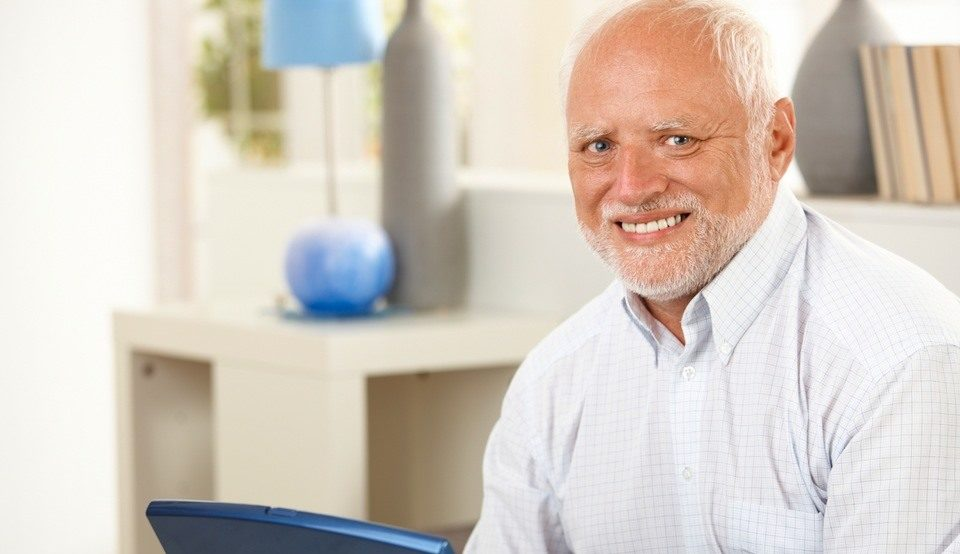

Valores nulos não ajudam em nada na hora de realizar uma regrssão linear, por isso vamos eliminar. Os códigos da célula abaixo foram tirados de um trabalho anterior que desenvolvi, ele pode ser encontrado [AQUI](https://www.kaggle.com/code/gabedossantos/house-prices-stacked-regression-top-8).

In [23]:
# Esta célula trata os valores nulos 

for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"):
    data[col] = data[col].fillna("None")
    
# Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Replacing missing values with none 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

# No garage no car
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
    
# No basement = 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
    
# For these categorical features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

# Filling in the Na values with the value that occues the most
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

# Drop the column 'Utilities'
data = data.drop(['Utilities'], axis=1)

# Typical as 'Typ'
data["Functional"] = data["Functional"].fillna("Typ")

# Only one missing value
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

# 'WD' is the most comom value
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

data['MSSubClass'] = data['MSSubClass'].fillna("None")

Vamos conferir as estatisticas novamente 

In [30]:
train, test = train_test_split(data, test_size=0.3, random_state=40)
train_stats = tfdv.generate_statistics_from_dataframe(train)
tfdv.visualize_statistics(train_stats)

## Criar um ESQUEMA

Um esquema define as propriedades dos dados e pode ser usado para detectar erros. Algumas dessas propriedades incluem: 

* Quais recursos devem estar presentes 
* Tipo da feature 
* Número de valores por feature 
* Os domínios esperados das features 

O esquema deve ser estático, enquanto as estatísticas podem variar de acordo com a divisão dos dados.Portanto, iremos criar um schema utilizando apenas os dados de treino. Posteriormente, geraremos estatísticas para conjunto de dados de teste para comparar e detectar anomalias. 

In [25]:
schema = tfdv.infer_schema(statistics=train_stats)
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Id',INT,required,,-
'MSSubClass',INT,required,,-
'MSZoning',STRING,required,,'MSZoning'
'LotFrontage',FLOAT,required,,-
'LotArea',INT,required,,-
'Street',STRING,required,,'Street'
'Alley',STRING,required,,'Alley'
'LotShape',STRING,required,,'LotShape'
'LandContour',STRING,required,,'LandContour'


,Values
Domain,
'MSZoning',"'C (all)', 'FV', 'RH', 'RL', 'RM'"
'Street',"'Grvl', 'Pave'"
'Alley',"'Grvl', 'None', 'Pave'"
'LotShape',"'IR1', 'IR2', 'IR3', 'Reg'"
'LandContour',"'Bnk', 'HLS', 'Low', 'Lvl'"
'LotConfig',"'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'"
'LandSlope',"'Gtl', 'Mod', 'Sev'"
'Neighborhood',"'Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'"
'Condition1',"'Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn'"


Através do esquema nós vemos quais são os tipos das variáveis, se sua presença é necessária ou não e quais são os domínios das variáveis.

## Visualizar anomalias

É importante que o esquema dos dados de teste seja consistente com os dados de treinamento, pois os dados que seu modelo receberá devem ser consistentes com os que foram usados para treino. Além disso, também é importante que as características dos dados de teste pertençam aproximadamente ao mesmo intervalo dos dados de treinamento. Isso garante que o modelo será avaliado em uma superfície de perda similar coberta durante o treinamento.

Agora iremos gerar as estatísticas de avaliação e compará-las com as estatísticas de treinamento, para isso vamos usar a função [generate_statistics_from_dataframe()](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/generate_statistics_from_dataframe), mas dessa vez iremos passar os dados de teste.

No entanto, é impraticável visualizar ambas as estatísticas separadamente e fazer sua comparação a partir daí, felizmente podemos usar TFDV para isso. podemos usar a função [visualize_statistics](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/visualize_statistics) e passar parâmetros adicionais para sobrepor as estatísticas de ambos os conjuntos de dados. Passamos:

* **lhs_statistics**: Parâmetro obrigatório. Espera uma instância de DatasetFeatureStatisticsList. 
* **rhs_statistics**: Espera uma instância de DatasetFeatureStatisticsList para comparar com lhs_statistics. 
* **lhs_name**: Nome do conjunto de dados lhs_statistics. 
* **rhs_name**: Nome do conjunto de dados rhs_statistics. 

In [26]:
eval_stats = tfdv.generate_statistics_from_dataframe(test)

tfdv.visualize_statistics(lhs_statistics=eval_stats, rhs_statistics=train_stats,
                          lhs_name='TEST_DATASET', rhs_name='TRAIN_DATASET')

As distribuições dos dados de treino e teste são parecidas. Vamos usar a função [tfdv.validate_statistics()](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/validate_statistics) para detectar anomalias.

In [27]:
anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)
tfdv.display_anomalies(anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'RoofMatl',Unexpected string values,Examples contain values missing from the schema: Membran (<1%).
'Condition2',Unexpected string values,Examples contain values missing from the schema: PosA (<1%).
'Neighborhood',Unexpected string values,Examples contain values missing from the schema: Blueste (<1%).
'HeatingQC',Unexpected string values,Examples contain values missing from the schema: Po (<1%).


Possuímos anomalias em 4 variáveis. De acordo com o nosso diagnóstico temos valores nos dados de treino que não estão nos dados de teste. Nós podemos consertar isso adicionando os novos valores que existem nos dados de treino ao domínio destas features 

In [28]:
# Pega o dominio relacionado com as features de entrada
HeatingQC_domain = tfdv.get_domain(schema, 'HeatingQC') 
Condition2_domain = tfdv.get_domain(schema, 'Condition2') 
Neighborhood_domain = tfdv.get_domain(schema, 'Neighborhood'	) 
RoofMatl_domain = tfdv.get_domain(schema, 'RoofMatl') 

# Adiciona os valores que faltam ao dominio 
HeatingQC_domain.value.append('Po')
Condition2_domain.value.append('PosA')
Neighborhood_domain.value.append('Blueste')
RoofMatl_domain.value.append('Membran')

anomalies = tfdv.validate_statistics(statistics=eval_stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [29]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Id',INT,required,,-
'MSSubClass',INT,required,,-
'MSZoning',STRING,required,,'MSZoning'
'LotFrontage',FLOAT,required,,-
'LotArea',INT,required,,-
'Street',STRING,required,,'Street'
'Alley',STRING,required,,'Alley'
'LotShape',STRING,required,,'LotShape'
'LandContour',STRING,required,,'LandContour'


,Values
Domain,
'MSZoning',"'C (all)', 'FV', 'RH', 'RL', 'RM'"
'Street',"'Grvl', 'Pave'"
'Alley',"'Grvl', 'None', 'Pave'"
'LotShape',"'IR1', 'IR2', 'IR3', 'Reg'"
'LandContour',"'Bnk', 'HLS', 'Low', 'Lvl'"
'LotConfig',"'Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'"
'LandSlope',"'Gtl', 'Mod', 'Sev'"
'Neighborhood',"'Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker', 'Blueste'"
'Condition1',"'Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn'"


Podemos notar o valor "Blueste" adicionado a feature "Neighborhood". 

## Conclusão 

Neste rápido tutorial, vimos o quão útil a ferramenta TFDV pode ser para nos auxiliar com a limpeza de dados. Esta ferramenta é utilizada em conjunto com[TFX](https://www.tensorflow.org/tfx) para criar um pipeline de dados. Este pipeline irá gerir toda a limpeza, treinamento e deploy de um determinado modelo. 

Um pipeline TFX é uma sequência de componentes que implementam um pipeline de ML projetado especificamente para tarefas de aprendizado de máquina escalonáveis ​​e de alto desempenho. Os componentes são construídos usando bibliotecas TFX que também podem ser usadas individualmente e sua grande vantagem é a possibilidade de lidar com grandes quantidades de dados. 